In [7]:
from astropy.io import fits
import pandas as pd
import numpy as np
import json

# Load the datasets
vis_main = fits.open('../data/vis_main.fits')[1].data

df = pd.DataFrame(np.array(vis_main))

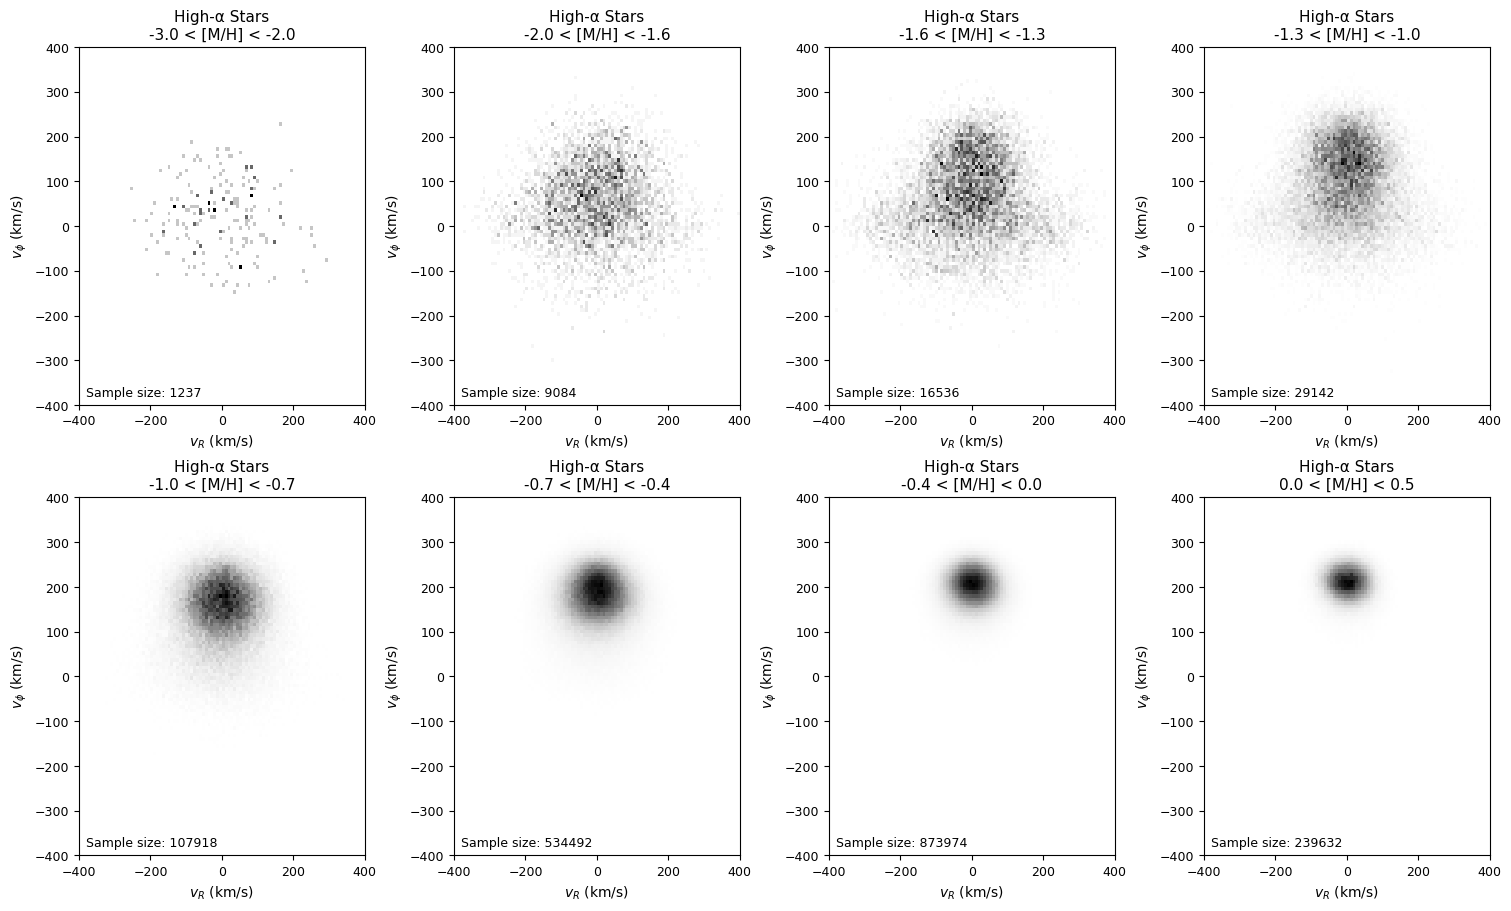

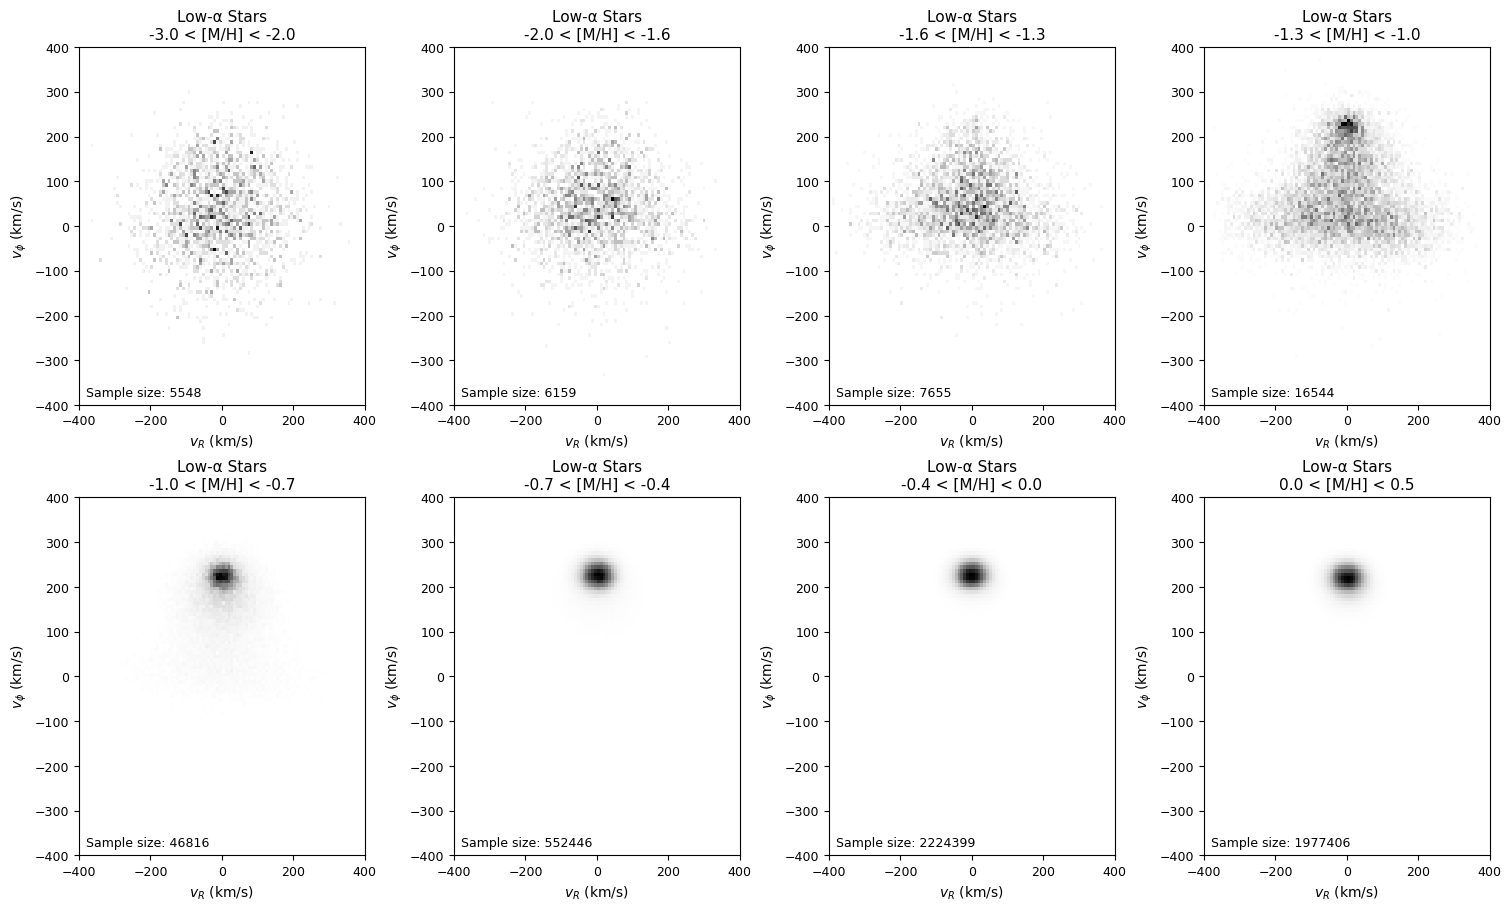

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_vr_vphi_by_metallicity(df, title_prefix, save_prefix=None):
    # Define metallicity bins and labels
    metallicity_bins = [-3.0, -2.0, -1.6, -1.3, -1.0, -0.7, -0.4, 0.0, 0.5]
    bin_labels = [
        "-3.0 < [M/H] < -2.0", "-2.0 < [M/H] < -1.6", "-1.6 < [M/H] < -1.3", "-1.3 < [M/H] < -1.0",
        "-1.0 < [M/H] < -0.7", "-0.7 < [M/H] < -0.4", "-0.4 < [M/H] < 0.0", "0.0 < [M/H] < 0.5"
    ]

    bins = 100
    x_limits = (-400, 400)
    y_limits = (-400, 400)

    fig, axes = plt.subplots(2, 4, figsize=(15, 9), constrained_layout=True)

    for i, (low, high) in enumerate(zip(metallicity_bins[:-1], metallicity_bins[1:])):
        df_filtered = df[(df["mh_xgboost"] > low) & (df["mh_xgboost"] <= high)]
        df_filtered = df_filtered.dropna(subset=["v_R", "v_phi"])

        # Compute 2D histogram
        H, xedges, yedges = np.histogram2d(
            df_filtered["v_R"],
            df_filtered["v_phi"],
            bins=bins, range=[x_limits, y_limits], density=True
        )

        # Min-max normalization
        H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
        H_max = np.max(H) if np.max(H) > 0 else 1
        H_normalized = (H - H_min) / (H_max - H_min)
        H_normalized = np.clip(H_normalized, 0, 1)

        ax = axes[i // 4, i % 4]
        im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

        ax.set_title(f"{title_prefix}\n{bin_labels[i]}", fontsize=11)
        ax.set_xlabel(r"$v_R$ (km/s)", fontsize=10)
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.text(x_limits[0] + 20, y_limits[0] + 20, f"Sample size: {len(df_filtered)}", fontsize=9)

    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()

# Define high and low alpha populations
df_high, df_low = define_alpha_sequences(df)

# Plot for both populations
plot_vr_vphi_by_metallicity(df_high, title_prefix="High-α Stars")
plot_vr_vphi_by_metallicity(df_low, title_prefix="Low-α Stars")


In [8]:
import sys
import os

src_path = os.path.abspath("../src")
sys.path.insert(0, src_path)

import pandas as pd
from tqdm import tqdm
from bic_vs_components import compute_bic_vs_n_components

def plot_bic_vs_n_components(BIC_values):
    """
    Plots BIC vs. Number of Components.

    Args:
    - BIC_values: Dictionary with BIC values for each component count.
    """
    num_components = sorted(BIC_values.keys())  # Sorted list of component numbers
    
    smallest_bic = [min(BIC_values[N]) for N in num_components]
    median_bic = [np.median(BIC_values[N]) for N in num_components]
    largest_bic = [max(BIC_values[N]) for N in num_components]
    q25_bic = [np.percentile(BIC_values[N], 25) for N in num_components]  # 25th percentile
    q75_bic = [np.percentile(BIC_values[N], 75) for N in num_components]  # 75th percentile

    plt.figure(figsize=(8, 6))
    plt.plot(num_components, smallest_bic, 'k-', label='Smallest BIC')
    plt.plot(num_components, q25_bic, 'g-.', label='25th Percentile BIC')
    plt.plot(num_components, median_bic, 'b--', label='Median BIC')
    plt.plot(num_components, q75_bic, '-.', label='75th Percentile BIC')
    plt.plot(num_components, largest_bic, 'r:', label='Largest BIC')

    plt.xlabel("Number of GMM Components")
    plt.ylabel("BIC Value")
    plt.title("BIC vs Number of Components")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
df_vmp_high = df_high[(df_high['mh_xgboost'] >= -3.0) & (df_high['mh_xgboost'] < -2.0)]
df_imp_high = df_high[(df_high['mh_xgboost'] >= -2.0) & (df_high['mh_xgboost'] < -1.6)]
df_mp1_high = df_high[(df_high['mh_xgboost'] >= -1.6) & (df_high['mh_xgboost'] < -1.3)]
df_mp2_high = df_high[(df_high['mh_xgboost'] >= -1.3) & (df_high['mh_xgboost'] < -1.0)]

df_vmp_low = df_low[(df_low['mh_xgboost'] >= -3.0) & (df_low['mh_xgboost'] < -2.0)]
df_imp_low = df_low[(df_low['mh_xgboost'] >= -2.0) & (df_low['mh_xgboost'] < -1.6)]
df_mp1_low = df_low[(df_low['mh_xgboost'] >= -1.6) & (df_low['mh_xgboost'] < -1.3)]
df_mp2_low = df_low[(df_low['mh_xgboost'] >= -1.3) & (df_low['mh_xgboost'] < -1.0)]


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [10:08<00:00, 76.02s/it] 


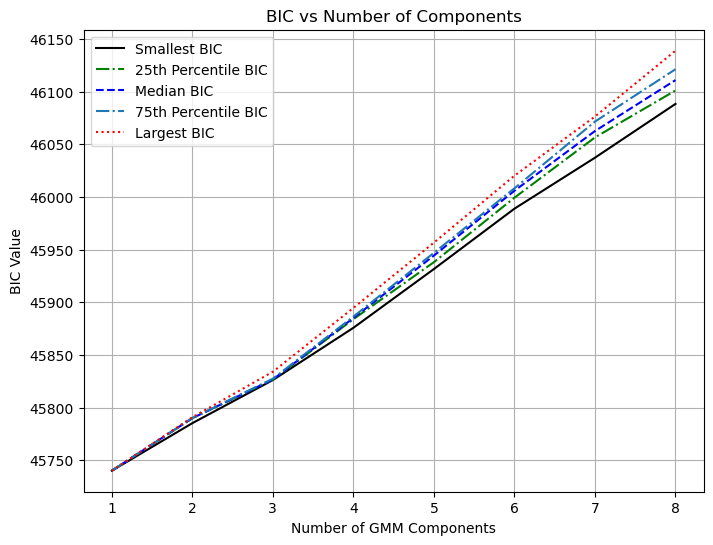

In [11]:
bic_vmp_high_alpha = compute_bic_vs_n_components(df_vmp_high, max_components=8, n_init=50)

with open("../fits/bic_vmp_high_alpha.json", "w") as f:
    json.dump(bic_vmp_high_alpha, f)

plot_bic_vs_n_components(bic_vmp_high_alpha)


Computing BIC for different numbers of components...


Fitting GMMs:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting GMMs: 100%|██████████| 8/8 [15:14<00:00, 114.31s/it]


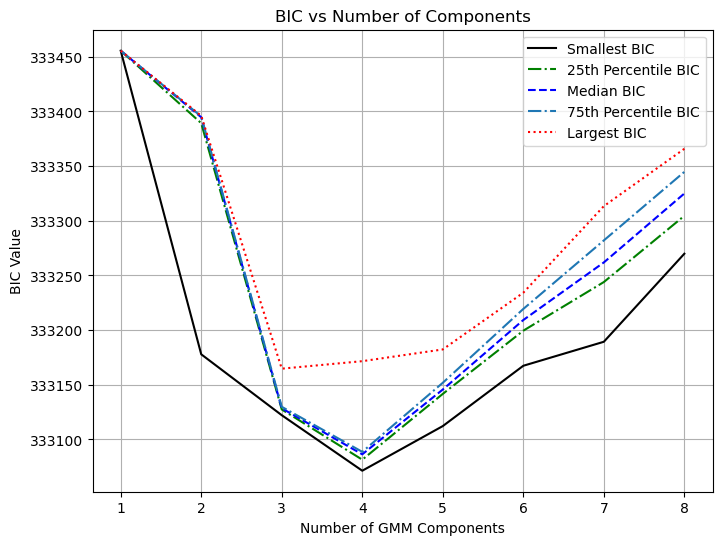

In [13]:
bic_imp_high_alpha = compute_bic_vs_n_components(df_imp_high, max_components=8, n_init=50)

with open("../fits/bic_imp_high_alpha.json", "w") as f:
    json.dump(bic_imp_high_alpha, f)

plot_bic_vs_n_components(bic_imp_high_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [24:40<00:00, 185.04s/it]


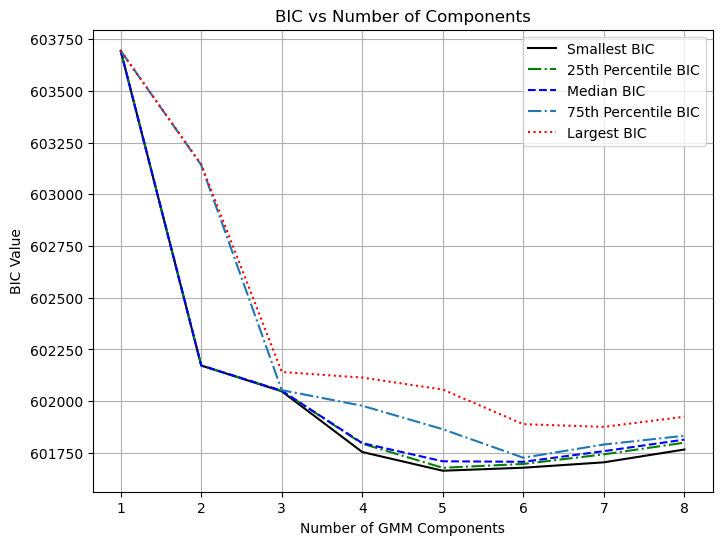

In [14]:
bic_mp1_high_alpha = compute_bic_vs_n_components(df_mp1_high, max_components=8, n_init=50)

with open("../fits/bic_mp1_high_alpha.json", "w") as f:
    json.dump(bic_mp1_high_alpha, f)

plot_bic_vs_n_components(bic_mp1_high_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [35:41<00:00, 267.66s/it]


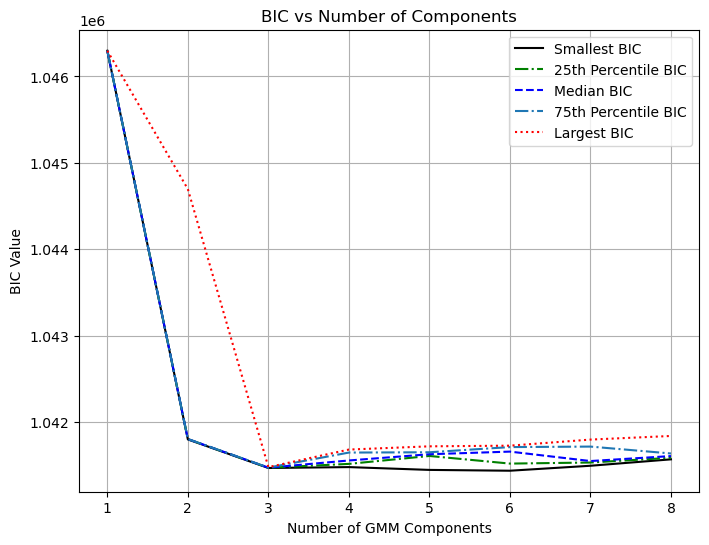

In [15]:
bic_mp2_high_alpha = compute_bic_vs_n_components(df_mp2_high, max_components=8, n_init=50)

with open("../fits/bic_mp2_high_alpha.json", "w") as f:
    json.dump(bic_mp2_high_alpha, f)

plot_bic_vs_n_components(bic_mp2_high_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [12:25<00:00, 93.24s/it] 


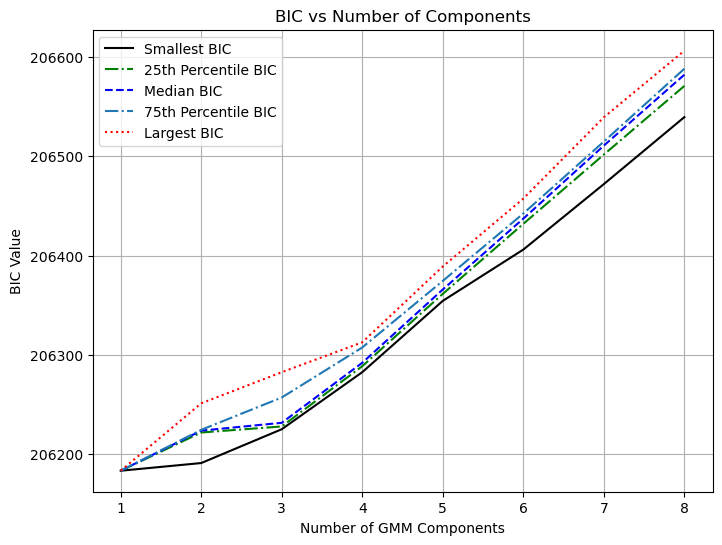

In [16]:
bic_vmp_low_alpha = compute_bic_vs_n_components(df_vmp_low, max_components=8, n_init=50)

with open("../fits/bic_vmp_low_alpha.json", "w") as f:
    json.dump(bic_vmp_low_alpha, f)

plot_bic_vs_n_components(bic_vmp_low_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [13:58<00:00, 104.87s/it]


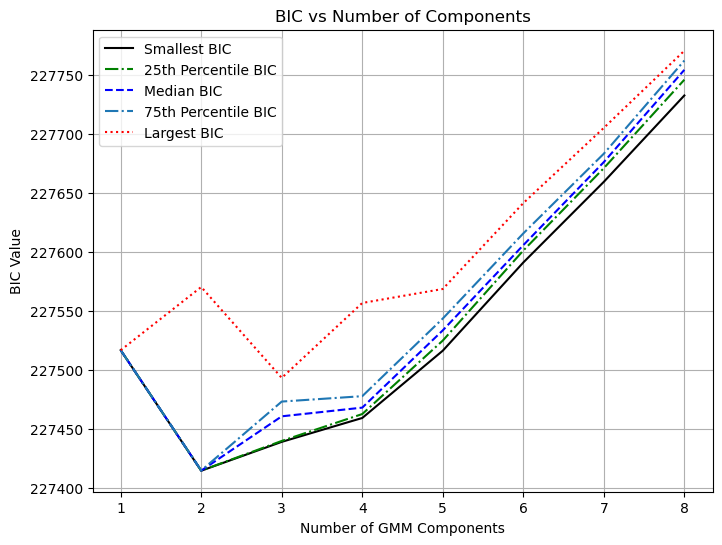

In [17]:
bic_imp_low_alpha = compute_bic_vs_n_components(df_imp_low, max_components=8, n_init=50)

with open("../fits/bic_imp_low_alpha.json", "w") as f:
    json.dump(bic_imp_low_alpha, f)

plot_bic_vs_n_components(bic_imp_low_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [14:50<00:00, 111.36s/it]


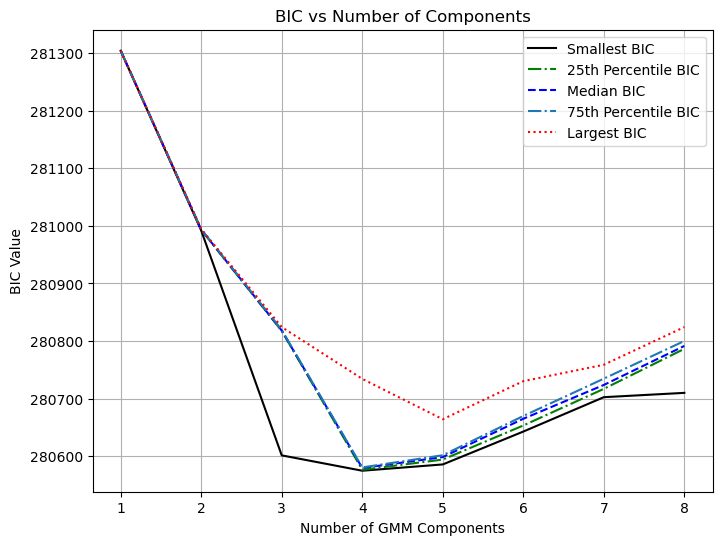

In [18]:
bic_mp1_low_alpha = compute_bic_vs_n_components(df_mp1_low, max_components=8, n_init=50)

with open("../fits/bic_mp1_low_alpha.json", "w") as f:
    json.dump(bic_mp1_low_alpha, f)

plot_bic_vs_n_components(bic_mp1_low_alpha)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [27:05<00:00, 203.17s/it]


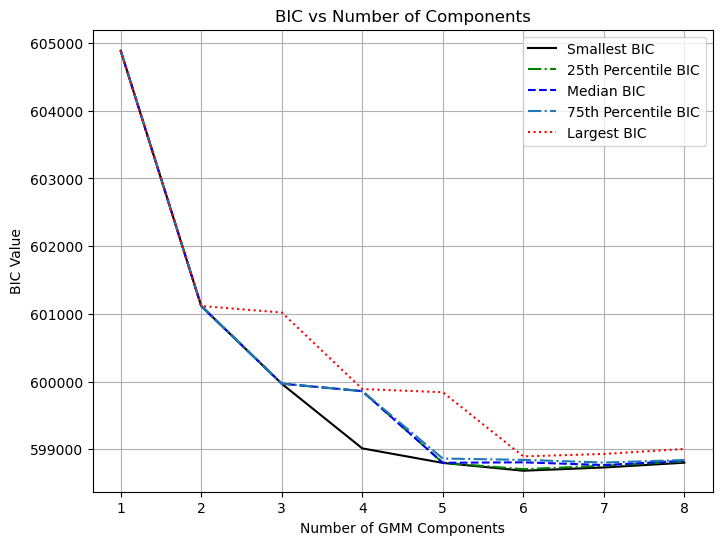

In [19]:
bic_mp2_low_alpha = compute_bic_vs_n_components(df_mp2_low, max_components=8, n_init=50)

with open("../fits/bic_mp2_low_alpha.json", "w") as f:
    json.dump(bic_mp2_low_alpha, f)

plot_bic_vs_n_components(bic_mp2_low_alpha)